<a href="https://colab.research.google.com/github/kcarnold/cs344/blob/main/portfolio/narrative/lab05-translation-transformers-lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Translation as Language Modeling

Goals:

* Practice getting data into and out of a language model (see [Fundamentals `013`](https://github.com/kcarnold/cs344/blob/main/portfolio/fundamentals/013-lm-logits-solutions.ipynb) for reference).
    * embeddings (input and output)
    * logits for next words
    * cross-entropy loss
* Explain how data flows between the encoder and decoder in a sequence-to-sequence model
* Interpret *attention weights*.

## Setup

Install libraries.

In [40]:
%pip install -U transformers
#tokenizers sentencepiece einops

Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.5.1)


Import PyTorch and the HuggingFace Transformers library.

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cpu'#torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load a [Marian Machine Translation](https://huggingface.co/transformers/model_doc/marian.html) model.

Specifically, we're using one that was trained on the OPUS corpus (`opus-mt`) to translate text in any romance language (`roa`) to English (`en`).

In [42]:
from transformers import MarianMTModel, MarianTokenizer
model_name = 'Helsinki-NLP/opus-mt-roa-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)

Finally, these wrappers will make the code below easier to understand (you should completely ignore them).

In [43]:
from functools import partial
from transformers.models.marian.modeling_marian import shift_tokens_right
prepend_start_token = partial(
    shift_tokens_right,
    pad_token_id = model.config.pad_token_id, decoder_start_token_id = model.config.decoder_start_token_id)
encoder = partial(model.get_encoder(), output_attentions=True, output_hidden_states=True)
decoder = partial(model.get_decoder(), output_attentions=True, output_hidden_states=True)


## Warm-up

Let's practice with the tokenizer. This should be mostly review, but we'll do it in the way that the HuggingFace docs do it.

In [44]:
src_text = "Yo les doy vida eterna."
batch = tokenizer(src_text, return_tensors='pt', padding=True).to(device)
batch

{'input_ids': tensor([[ 2554,    29,    73,   131,   860, 21658,     3,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

Since we're only translating one sentence, we can ignore `attention_mask` (which just helps ignore padding tokens) and the extra initial dimension of the `input_ids`.

In [45]:
input_ids = batch['input_ids']
input_ids.shape

torch.Size([1, 8])

In [46]:
tokenizer.convert_ids_to_tokens(input_ids[0])

['▁Yo', '▁les', '▁do', 'y', '▁vida', '▁eterna', '.', '</s>']

Now let's ask the model to generate a translation. Lots of magic happens here; we'll peel back the layers shortly.

In [47]:
translated = model.generate(input_ids = input_ids)
translated.shape

torch.Size([1, 8])

Decode the result!

In [72]:
with tokenizer.as_target_tokenizer():
    tgt_text = tokenizer.decode(translated[0][1:])
tgt_text

'I give them eternal life.'

In [73]:
with tokenizer.as_target_tokenizer():
    tgt_batch = tokenizer(tgt_text, return_tensors='pt', padding=True).to(device)
tgt_batch

{'input_ids': tensor([[   20,   685,   224, 16762,   482,     3,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

## Dig In!

Ok now how did it do that?

https://huggingface.co/transformers/model_doc/marian.html#transformers.MarianMTModel.forward

First, let's look at the *loss* that the model gives. We'll compare the correct translation with an incorrect one:

In [74]:
with tokenizer.as_target_tokenizer():
    wrong_target = "I give them eternal death."
    wrong_target_batch = tokenizer(wrong_target, return_tensors='pt', padding=True).to(device)
wrong_target_batch

{'input_ids': tensor([[   20,   685,   224, 16762,  1743,     3,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

Let's **run a forward pass through the full model** (encoder and decoder) with the complete candidate translation. First, the correct translation:

In [75]:
with torch.no_grad():
    model_outputs = model(
        input_ids = batch['input_ids'],
        labels = tgt_batch['input_ids']
    )
model_outputs.loss

tensor(0.2088)

Now (**your turn**) the incorrect translation:

In [76]:
# your code here
with torch.no_grad():
    model_outputs = model(
        input_ids = batch['input_ids'],
        labels = wrong_target_batch['input_ids']
    )
model_outputs.loss

tensor(1.3203)

### The guts of the model

I've ripped out all the plumbing code and things you only need in special situations to just show the guts of the model below. **Study this code carefully** with the help of the questions below it.

In [77]:
encoder_input_ids = batch['input_ids']
target_ids = tgt_batch['input_ids']
decoder_input_ids = prepend_start_token(target_ids)

with torch.no_grad():
    encoder_outputs = encoder(input_ids = encoder_input_ids)

    decoder_outputs = decoder(
        input_ids = decoder_input_ids,
        encoder_hidden_states = encoder_outputs.last_hidden_state
    )

    output_embedding = decoder_outputs.last_hidden_state
    logits = output_embedding @ model.lm_head.weight.t()
    logits += model.final_logits_bias

    # ignore the batch dimension.
    logits = logits[0]

nlls_of_correct_tokens = F.cross_entropy(logits, target_ids[0], reduction='none')
nlls_of_correct_tokens.mean()

tensor(0.2088)

*Explain `logits.shape`*.

In [78]:
logits.shape

torch.Size([7, 65001])

*your narrative answer here*
It gives the 

In [79]:
tokenizer.convert_ids_to_tokens(logits.argmax(dim=1))

['▁I', '▁give', '▁them', '▁eternal', '▁life', '.', '</s>']

In [80]:
tokenizer.convert_ids_to_tokens(target_ids[0])

['▁I', '▁give', '▁them', '▁eternal', '▁life', '.', '</s>']

What tensor contains all of the information from the Spanish sentence that is used to generate the English sentence?

Explain each element of the shape of that tensor. (The leading "1" is the batch dimension; you can ignore this unless you're translating multiple sentence simultaneously.)

In [81]:
encoder_outputs.last_hidden_state.shape

torch.Size([1, 8, 512])

In [86]:
model.config.num_hidden_layers

6

## Visualize attentions

Read these as: the row token looks at the column token.

There are actually 8 attention heads for each of the 6 layers, so to visualize simply, we take the mean over the attention weights (which are all positive).

In [87]:
decoder_outputs.cross_attentions[0].shape

torch.Size([1, 8, 7, 8])

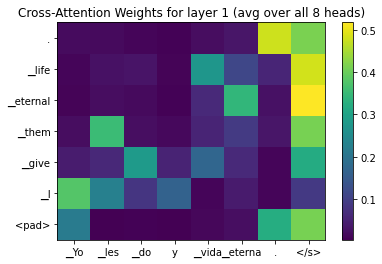

In [83]:
layer = 1
plt.pcolormesh(decoder_outputs.cross_attentions[layer][0].mean(dim=0).cpu().numpy())
plt.title(f"Cross-Attention Weights for layer {layer} (avg over all {model.config.num_attention_heads} heads)")
plt.xticks(torch.arange(8)+.5, tokenizer.convert_ids_to_tokens(encoder_input_ids[0]))
plt.yticks(torch.arange(7)+.5, tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
plt.colorbar();

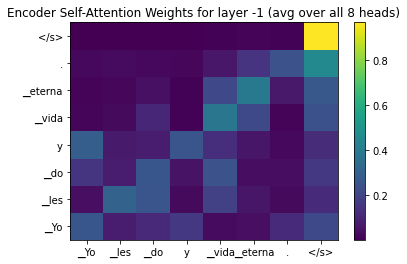

In [84]:
layer = -1
plt.pcolormesh(encoder_outputs.attentions[layer][0].mean(dim=0).cpu().numpy())
plt.title(f"Encoder Self-Attention Weights for layer {layer} (avg over all {model.config.num_attention_heads} heads)")
plt.xticks(torch.arange(8)+.5, tokenizer.convert_ids_to_tokens(encoder_input_ids[0]))
plt.yticks(torch.arange(8)+.5, tokenizer.convert_ids_to_tokens(encoder_input_ids[0]))
plt.colorbar();

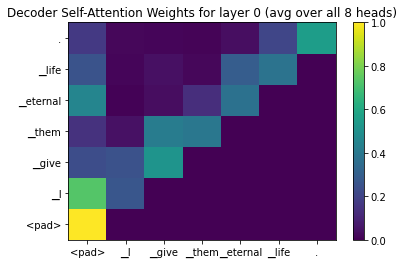

In [85]:
layer = 0
plt.pcolormesh(decoder_outputs.attentions[layer][0].mean(dim=0).cpu().numpy())
plt.title(f"Decoder Self-Attention Weights for layer {layer} (avg over all {model.config.num_attention_heads} heads)")
plt.xticks(torch.arange(7)+.5, tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
plt.yticks(torch.arange(7)+.5, tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
plt.colorbar();

* Look at internal structure of the model (what's its dimensionality? how many layers?)
* Look at token embeddings (similarity)
* Look at logit lens


In [88]:
# http://stephantul.github.io/python/pytorch/2020/09/18/fast_topk/
def get_ranks(values, indices):
    targets = values[range(len(values)), indices]
    return (values > targets[:, None]).long().sum(dim=1)

In [89]:
tgt_batch.input_ids

tensor([[   20,   685,   224, 16762,   482,     3,     0]])

In [90]:
ranks = []
print(tokenizer.convert_ids_to_tokens(decoder_input_ids[0]))
for hidden in decoder_outputs.hidden_states[1:]:
    x = model.lm_head(hidden)[0]
    print(tokenizer.convert_ids_to_tokens(x.argmax(dim=1)))
    ranks.append(get_ranks(x, target_ids[0]))
torch.stack(ranks)


['<pad>', '▁I', '▁give', '▁them', '▁eternal', '▁life', '.']
['▁prevailed', 'oping', '▁give', '▁them', '▁MR', '▁life', 'dog']
['▁foi', 'quarter', '▁give', '▁themselves', '▁Basket', '▁life', 'com']
['▁foi', "'", '▁them', '▁a', 'ly', '▁-', '▁It']
['▁foi', "'", '▁them', '▁all', 'ly', ',', '▁[']
['▁"', "'", '▁them', '▁life', '▁life', ',', '▁[']
['▁I', '▁give', '▁them', '▁eternal', '▁life', ',', '▁-']


tensor([[40330,  5603,  6987, 18888, 12455, 26906, 25097],
        [ 9279, 15847,     4, 12473,   109, 21494,  9482],
        [ 1519,  1556,     0, 21065,    60, 22421,  2793],
        [  123,   197,     0, 15263,     3, 12010,   613],
        [    4,     1,     0,    17,     0,   131,    48],
        [    0,     0,     0,     0,     0,     3,    10]])

In [91]:
target_ids.shape

torch.Size([1, 7])